We need to install the leafmap client for data visualization in the notebook.

**Note:** This is set to run silently so you will not see an output when executing this cell. If you'd like to ensure the package downloads successfully remove the `--quiet` flag

![HLS Training](../images/HLS-inference.png)

#### If using a regular Python venv select this option

In [1]:
! pip install ipyleaflet numpy --quiet

# Restart kernel, and hard refresh the browser

#### If using Anaconda/conda this might work better
It will take a LOT longer to install ~10 minutes

Import the python libraries required for running the script

In [2]:
import json
import ipyleaflet
import numpy as np

This is a dictionary contains several sample cases of burn scars across the globe. These configuration settings will automatically set the location of the map for AOI selection and the start_date and end_date to perform the data query.

In [3]:
#configure settings for selected events
INFERENCE_URL = 'https://hls-01.workshop.nasa-impact.net/'

EVENT_DETAILS = {
    'mongolian_fire': {
        'center_lon': 119.3,
        'center_lat': 47.1,
        'default_zoom': 8,
        'start_date': '2022-04-19T00:00:00Z',
        'end_date': '2022-04-19T23:59:59Z'
    },
    'new_mexico_black_fire': {
        'center_lon': -107.5,
        'center_lat': 33.5,
        'default_zoom': 10,
        'start_date': '2022-05-16T00:00:00Z',
        'end_date': '2022-06-10T23:59:59Z'
    },
    'alberta_fire': {
        'center_lon': -124.2,
        'center_lat': 61.8,
        'default_zoom': 8,
        'start_date': '2023-05-27T00:00:00Z',
        'end_date': '2023-05-28T23:59:59Z'
    },
    'maui_fire': {
        'center_lon': -156.659394,
        'center_lat': 20.886984,
        'default_zoom': 12,
        'start_date': '2023-08-13T00:00:00Z',
        'end_date': '2023-08-13T23:59:59Z'
    }
}

Select the predefined event of your choice from above. If you'd like to execute a different event, the simplest way to implement it would be to add the event details as a new key in the dictionary

In [4]:
event = 'maui_fire'
event_details = EVENT_DETAILS[event]

In [5]:
datestring = event_details['start_date']
HLSL30_TILE_LAYER = 'https://gitc-a.earthdata.nasa.gov/wmts/epsg3857/best/wmts.cgi?TIME=' + datestring + '&layer=HLS_L30_Nadir_BRDF_Adjusted_Reflectance&style=default&tilematrixset=GoogleMapsCompatible_Level12&Service=WMTS&Request=GetTile&Version=1.0.0&Format=image%2Fpng&TileMatrix={z}&TileCol={x}&TileRow={y}'
HLSS30_TILE_LAYER = 'https://gitc-a.earthdata.nasa.gov/wmts/epsg3857/best/wmts.cgi?TIME=' + datestring + '&layer=HLS_S30_Nadir_BRDF_Adjusted_Reflectance&style=default&tilematrixset=GoogleMapsCompatible_Level12&Service=WMTS&Request=GetTile&Version=1.0.0&Format=image%2Fpng&TileMatrix={z}&TileCol={x}&TileRow={y}'

Initialize map with one of the canned examples listed above, and HLS XYZ Layers from NASA Worldview. If you would like execute a custom use case, please navigate to your desired AOI, draw a bounding box, and update the start_date and end_date in the prepare_items method

In [6]:
from ipyleaflet import Map, TileLayer, DrawControl, GeoJSON

In [7]:
layer = TileLayer(url=HLSL30_TILE_LAYER, attribution='NASA',name='HLSL30', opacity=1)
draw_control = DrawControl()
map = Map(
        default_tiles=layer,
        center=(event_details['center_lat'],
        event_details['center_lon']), 
        zoom=event_details['default_zoom']
    )

draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 0.3
    }
}
hlsl30_tile_layer = TileLayer(url=HLSL30_TILE_LAYER, name='HLSL30', attribution='NASA')
hlss30_tile_layer = TileLayer(url=HLSS30_TILE_LAYER, name='HLSL30', attribution='NASA')
map.add_layer(hlsl30_tile_layer)
map.add_layer(hlss30_tile_layer)

map.add(draw_control)

# Store drawn shapes
drawn_shapes = []

# Define a function to handle drawing events
def handle_draw(self, action, geo_json):
    if action == 'created':
        drawn_shapes.append(geo_json)
        print("Shape added.")

# Attach the drawing event handler to the drawing control
draw_control.on_draw(handle_draw)
# map.add(layer)
map

Map(center=[20.886984, -156.659394], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

This cell saves the bounding box drawn by the user.

**WARNING:** if you skip the next step, the notebook will not find any HLS data as there will be no bounding box information.

**WARNING:** if you skipped the previous step, the notebook will not find any HLS data as there will be no bounding box information.

In [8]:
# Read the bounding box and print
bbox = drawn_shapes[0]

IndexError: list index out of range

We will utilize the trained model, changed configuration file, and the date information to get a prediction on the selected region.

In [9]:

def bbox_from_geojson(bbox):
    """
        Get the coordinates of bounding box from an extended notation to flat coordinate
        notation
    Args:
        geojson: File path of geojson

    Returns:
        list: [left, down, right, top]
    """
    coordinates = np.asarray(bbox['geometry']['coordinates'])
    lats = coordinates[:, :, 1]
    lons = coordinates[:, :, 0]
    return [lons.min(), lats.min(), lons.max(), lats.max()]

In [10]:
# Convert geojson to flat bounding box representation.
bbox = bbox_from_geojson(bbox)
bbox

NameError: name 'bbox' is not defined

Note: `BUCKET_NAME`, and `identifier` are variables set in the previous notebook. Please copy paste those variables here for this step to run smoothly.


In [ ]:
BUCKET_NAME = <Update>
identifier = <Update> 

config_filename = 'configs/burn_scars_Prithvi_100M.py'
new_config_filename = f"configs/{identifier}-burn_scars_Prithvi_100M.py"
MODEL_NAME = f"{identifier}-workshop.pth"

In [ ]:
import requests
import json

# prepare payload

payload = json.dumps({
  "config_path": f"s3://{BUCKET_NAME}/data/{new_config_filename}",
  "model_path": f"s3://{BUCKET_NAME}/models/{MODEL_NAME}",
  "model_type": "burn_scars",
  "date": event_details['start_date'].split('T')[0],
  "bounding_box": bbox
})

headers = {
  'Content-Type': 'application/json'
}

# Use deployed app to get inference on the selected date/location
response = requests.request(
      "POST", 
      f"{INFERENCE_URL}infer", 
      headers=headers, 
      data=payload
  )

predictions = response.json()

predictions

In [ ]:
geojson = predictions['predictions']

detection_map = Map(
        center=(event_details['center_lat'],
        event_details['center_lon']), 
        zoom=event_details['default_zoom'], 
    )
detection_map.add(hlsl30_tile_layer)
detection_map.add(hlss30_tile_layer)
detection_map.add(GeoJSON(data=geojson))

detection_map

In [4]:
import geopandas as gpd
# Open ROI polygon
roi = gpd.read_file('../data/Field_Boundary.geojson')

In [110]:
from pystac_client import Client
from planetary_computer import sign
from shapely.geometry import shape, mapping

# --- Load GeoJSON Polygon ---
geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "coordinates": [
                    [
                        [-122.09684570249401, 39.90665319161309],
                        [-122.09382925224304, 39.89913263372122],
                        [-122.09381158862462, 39.89193960036616],
                        [-122.0452080243209, 39.89362074700392],
                        [-122.03465069273044, 39.89728856017888],
                        [-122.0503870926483, 39.92326328372664],
                        [-122.09102285952527, 39.90997156746636],
                        [-122.09684570249401, 39.90665319161309]
                    ]
                ],
                "type": "Polygon"
            }
        }
    ]
}
polygon_geom = shape(geojson["features"][0]["geometry"])

# --- Perform STAC Search ---
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=mapping(polygon_geom),
    datetime="2021-06-01/2021-06-30",
    limit=5
)

items = list(search.items())
print(f"Found: {len(items)} granules")

# --- Display Results ---
if items:
    for i, item in enumerate(items):
        signed_item = sign(item)
        print(f"\n{i}: {item.id}")
        print("  Date:", item.datetime)
        print("  Assets:", list(signed_item.assets.keys()))
        if "thumbnail" in signed_item.assets:
            print("  Thumbnail preview:", signed_item.assets["thumbnail"].href)
        elif "rendered_preview" in signed_item.assets:
            print("  Rendered preview:", signed_item.assets["rendered_preview"].href)
else:
    print("No STAC items returned.")


Found: 12 granules

0: S2A_MSIL2A_20210628T184921_R113_T10TEK_20210630T054019
  Date: 2021-06-28 18:49:21.024000+00:00
  Assets: ['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual', 'preview', 'safe-manifest', 'granule-metadata', 'inspire-metadata', 'product-metadata', 'datastrip-metadata', 'tilejson', 'rendered_preview']
  Rendered preview: https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=sentinel-2-l2a&item=S2A_MSIL2A_20210628T184921_R113_T10TEK_20210630T054019&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0&format=png

1: S2B_MSIL2A_20210626T185919_R013_T10TEK_20210627T030008
  Date: 2021-06-26 18:59:19.024000+00:00
  Assets: ['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'visual', 'preview', 'safe-manifest', 'granule-metadata', 'inspire-metadata', 'product-metadata', 'datastrip-metadata', 'tilejson', 'rendered_preview']
  Rend

In [ ]:
import pystac_client
catalog = pystac_client.Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")
# Define search parameters
search_params = {
    "collections": ["HLSS30_2.0","HLSL30_2.0"],
    "bbox": tuple(list(roi.total_bounds)),
    "datetime": "2021-05-01/2021-09-30",
    "limit": 100,
}
# Perform the search
query = catalog.search(**search_params)
items = query.items()

In [101]:
import pystac_client

# Connect to Planetary Computer STAC API
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
bbox = [-122.5, 37.7, -122.3, 37.9]  # San Francisco area



search = catalog.search(
    collections=["cop-dem-glo-30"],
    bbox=bbox,
    limit=1
)
items = list(search.items())
# Sample dict_keys(['data', 'tilejson', 'rendered_preview'])
print(signed_item.assets.keys())
print(f"Found {len(items)} items.")
print(f"Matched: {search.matched()}")
if items:
    print(items[0].to_dict())
else:
    print("No items found.")



dict_keys(['data', 'tilejson', 'rendered_preview'])
Found 1 items.
Matched: None
{'type': 'Feature', 'stac_version': '1.1.0', 'stac_extensions': ['https://stac-extensions.github.io/projection/v2.0.0/schema.json'], 'id': 'Copernicus_DSM_COG_10_N37_00_W123_00_DEM', 'geometry': {'type': 'Polygon', 'coordinates': [[[-122.00013889, 37.00013889], [-122.00013889, 38.00013889], [-123.00013889, 38.00013889], [-123.00013889, 37.00013889], [-122.00013889, 37.00013889]]]}, 'bbox': [-123.00013888888888, 37.00013888888889, -122.00013888888888, 38.00013888888889], 'properties': {'gsd': 30, 'datetime': '2021-04-22T00:00:00Z', 'platform': 'TanDEM-X', 'proj:shape': [3600, 3600], 'proj:transform': [0.0002777777777777778, 0.0, -123.00013888888888, 0.0, -0.0002777777777777778, 38.00013888888889], 'proj:code': 'EPSG:4326'}, 'links': [{'rel': 'collection', 'href': 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/cop-dem-glo-30', 'type': 'application/json'}, {'rel': 'parent', 'href': 'https://

C:\Users\carnu\Documents\Clients\NASA\pystac-client\pystac_client\item_search.py:728: UserWarning: numberMatched or context.matched not in response
  warnings.warn("numberMatched or context.matched not in response")


In [102]:
if items:
    for i, item in enumerate(items):
        print(items[i])
        print(f"{i}: {item.id} - Assets: {list(item.assets.keys())}")
else:
    print("No STAC items returned.")


<Item id=Copernicus_DSM_COG_10_N37_00_W123_00_DEM>
0: Copernicus_DSM_COG_10_N37_00_W123_00_DEM - Assets: ['data', 'tilejson', 'rendered_preview']


In [104]:
items[1]

IndexError: list index out of range

In [105]:
from planetary_computer import sign

signed_item = sign(items[0])
print(signed_item.assets.keys())
print(signed_item.assets["rendered_preview"].href)  

dict_keys(['data', 'tilejson', 'rendered_preview'])
https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=cop-dem-glo-30&item=Copernicus_DSM_COG_10_N37_00_W123_00_DEM&assets=data&colormap_name=terrain&rescale=-1000%2C4000&format=png


<xarray.DataArray (band: 1, y: 3600, x: 3600)> Size: 52MB
[12960000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB -123.0 -123.0 -123.0 ... -122.0 -122.0 -122.0
  * y            (y) float64 29kB 38.0 38.0 38.0 38.0 ... 37.0 37.0 37.0 37.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0


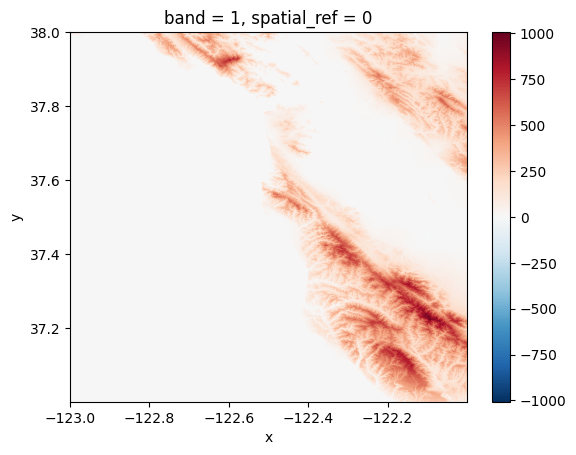

In [106]:
from planetary_computer import sign
import rioxarray

# Sign the item
signed_item = sign(items[0])

# Load the elevation data as xarray
elevation_url = signed_item.assets["data"].href
elevation = rioxarray.open_rasterio(elevation_url, masked=True)

print(elevation)
elevation.plot()

In [107]:
items = list(query.items())
print(f"Found: {len(items):d} granules")

Found: 0 granules


In [78]:
# Rename HLSS B8A and HLSL B05 to common band name
for item in items:
    if "HLS.L30" in item.id:
        item.assets["NIR"] = item.assets.pop("B05")
    if "HLS.S30" in item.id:
        item.assets["NIR"] = item.assets.pop("B8A")

In [79]:
# Confirm this changed the stac results
items[0]

IndexError: list index out of range

In [17]:
import odc.stac
# Set CRS and resolution, open lazily with odc.stac
crs = "utm"
ds = odc.stac.stac_load(
    items,
    bands=("B02", "B04","NIR", "Fmask"),
    crs=crs,
    resolution=30,
    chunks={"band":1,"x":512,"y":512},  # If empty, chunks along band dim, 
    #groupby="solar_day", # This limits to first obs per day
)
display(ds)

<xarray.Dataset> Size: 17GB
Dimensions:      (y: 3667, x: 3661, time: 78)
Coordinates:
  * y            (y) float64 29kB 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06
  * x            (x) float64 29kB 5e+05 5e+05 5.001e+05 ... 6.098e+05 6.098e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 624B 2021-05-02T19:13:19.930000 ... 20...
Data variables:
    B02          (time, y, x) float32 4GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    B04          (time, y, x) float32 4GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    NIR          (time, y, x) float32 4GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    Fmask        (time, y, x) float32 4GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

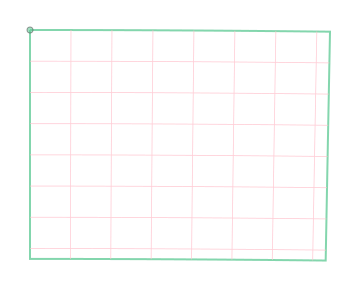

In [18]:
# Show Geobox
ds.odc.geobox

In [21]:
import rasterio as rio
import rioxarray as rxr
# Clip
ds = ds.rio.clip(roi.geometry.values, roi.crs, all_touched=True)

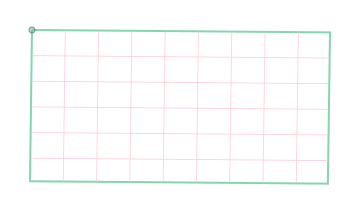

In [22]:
# Show Clipped Geobox
ds.odc.geobox

In [23]:
# Scale the data
ds.NIR.data = 0.0001 * ds.NIR.data
ds.B04.data = 0.0001 * ds.B04.data
ds.B02.data = 0.0001 * ds.B02.data

In [25]:
print(ds)

<xarray.Dataset> Size: 26MB
Dimensions:      (y: 118, x: 179, time: 78)
Coordinates:
  * y            (y) float64 944B 4.42e+06 4.42e+06 ... 4.416e+06 4.416e+06
  * x            (x) float64 1kB 5.772e+05 5.772e+05 ... 5.825e+05 5.825e+05
  * time         (time) datetime64[ns] 624B 2021-05-02T19:13:19.930000 ... 20...
    spatial_ref  int64 8B 0
Data variables:
    B02          (time, y, x) float32 7MB dask.array<chunksize=(1, 118, 179), meta=np.ndarray>
    B04          (time, y, x) float32 7MB dask.array<chunksize=(1, 118, 179), meta=np.ndarray>
    NIR          (time, y, x) float32 7MB dask.array<chunksize=(1, 118, 179), meta=np.ndarray>
    Fmask        (time, y, x) float32 7MB dask.array<chunksize=(1, 118, 179), meta=np.ndarray>
